<a href="https://colab.research.google.com/github/ptran1203/gan_project/blob/master/try_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
cd /content

/content


In [2]:
%tensorflow_version 1.x
from google.colab import drive, output
drive.mount('/content/drive')

!rm -rf '/content/gan_project'
!git clone https://github.com/ptran1203/gan_project
!pip install git+https://www.github.com/keras-team/keras-contrib.git

output.clear

TensorFlow 1.x selected.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Cloning into 'gan_project'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (122/122), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 2394 (delta 72), reused 77 (delta 34), pack-reused 2272
Receiving objects: 100% (2394/2394), 1.59 MiB | 1.76 MiB/s, done.
Resolving deltas: 100% (1514/1514), done.
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-dpiu2a4v
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-dpiu2a4v
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101064 sha256=7ede63f109dc565de10fb40b211ee0bf8f46f6da540eb798b46ec81cd26ec963
  Stored in directory: /tmp/pip-ephem-wheel-cache-bbughzrz/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Succe

<function google.colab.output._tags.clear>

## Create the link from this drive folder to your drive.

---


https://drive.google.com/drive/folders/1RNJXceXkNatuAbNn-CKB8MrgaEHG5RpM?usp=sharing

In [3]:
cd gan_project

/content/gan_project


In [15]:

# K.common.set_image_dim_ordering('tf')
BASE_DIR = '/content/drive/My Drive/bagan'
DS_DIR = '/content/drive/My Drive/bagan/dataset/chest_xray'
DS_SAVE_DIR = '/content/drive/My Drive/bagan/dataset/save'
gratio_mode = 'uniform'
dratio_mode = 'uniform'

from new_gan import *
from batch_gen import *
from utils import *
from tensorflow.keras.layers import LayerNormalization

def create_dir_if_any(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

class Bagan(BalancingGAN):
    attribute_loss_weight = 0
    def interval_process(self, epoch):
        if epoch % 400 == 0 and epoch > 0:
            output.clear()
    
    def get_pair_features(self, image_batch): return 0,0
    # def backup_point(self, epoch): return
    def evaluate_d(self, test_x, test_y): return
    def evaluate_g(self, test_x, test_y): return

    def build_features_from_d_model(self):
        image = Input(shape=(self.resolution, self.resolution, self.channels))
        print(self.discriminator.layers)
        model_output = self.discriminator.layers[-3](image)
        
        self.features_from_d_model = Model(
            inputs = image,
            output = model_output,
            name = 'Feature_matching'
        )

    def compute_multivariate(self, bg):
        if self.sampling == 'normal':
            return

        print("Computing feature distribution")
        if not hasattr(self, 'covariances'):
            self.covariances = []
            self.means = []
        else:
            self.covariances = list(self.covariances)
            self.means = list(self.means)

        for c in np.unique(bg.dataset_y):
            imgs = bg.dataset_x[bg.per_class_ids[c]]
            imgs = utils.triple_channels(imgs)
            latent = self.latent_encoder.predict(imgs)
            
            self.covariances.append(np.cov(np.transpose(latent)))
            self.means.append(np.mean(latent, axis=0))

        self.covariances = np.array(self.covariances)
        self.means = np.array(self.means)


class BatchGen(BatchGenerator):
    # to_train_classes = list(range(0, 5))
    to_train_classes = INVERT_CATEGORIES_MAP[:2]
    to_test_classes = list(range(81, 86))


is_test = 0
## Test batch GEN
if is_test:
    bg = BatchGen(BatchGen.TRAIN, 64, 'multi_chest', 64)
    labels = np.array([0, 0, 1, 1, 2, 2, 3 ,1])
    samples = bg.ramdom_kshot_images(4, labels)
    print(samples.shape)

## **Run experiment**

---



load data from /content/drive/My Drive/bagan/dataset/multi_chest/imgs_labels_64.pkl successfully
2000 2000
load data from /content/drive/My Drive/bagan/dataset/multi_chest/imgs_labels_64.pkl successfully
10679 10679
input data loaded...
img shape (64, 64, 1)
Class counters:  [1000, 1000]

=================== GAN Setting ==================

- Dataset: multi_chest
- Num of classes: 2
- Generator type: Resnet
- Self-Attention: False
- K-shot: 2
- Adverasial loss: hinge
- Normalization: Instance norm
- Use feature normaliztion: True


Latent model modified at:  2020-06-23 05:32:46
[<keras.engine.input_layer.InputLayer object at 0x7ff5e74dd550>, <keras.layers.convolutional.Conv2D object at 0x7ff5e74ddb00>, <keras.layers.advanced_activations.LeakyReLU object at 0x7ff5e74ddc88>, <keras.layers.core.Dropout object at 0x7ff5e74dde80>, <keras.layers.convolutional.Conv2D object at 0x7ff5e74e51d0>, <keras.layers.advanced_activations.LeakyReLU object at 0x7ff5e7476fd0>, <keras.layers.core.Dropout ob

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., name="Feature_matching", outputs=Tensor("dr...)`


Use Batch norm for FeatureNorm layer
Use Batch norm for FeatureNorm layer
Use Batch norm for FeatureNorm layer
Use Batch norm for FeatureNorm layer
Use Batch norm for FeatureNorm layer
Use Batch norm for FeatureNorm layer
Use Batch norm for FeatureNorm layer
Use Batch norm for FeatureNorm layer
Use Batch norm for FeatureNorm layer
Use Batch norm for FeatureNorm layer
Use Batch norm for FeatureNorm layer
['loss', 'discriminator_loss', 'model_3_loss', 'discriminator_accuracy', 'model_3_accuracy']
['loss', 'accuracy']
init gan
Computing feature distribution
Computing feature distribution
GAN weight initialized, train from epoch  0
Reload error, restart from scratch  join() argument must be str or bytes, not 'NoneType'
gan initialized, start_e:  0


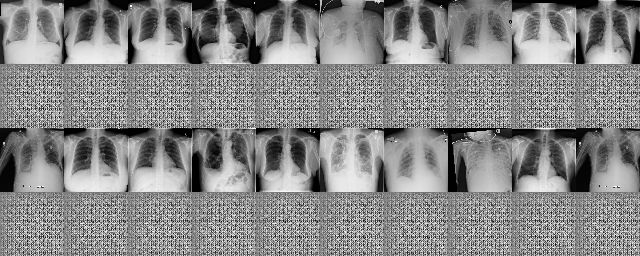

GAN train epoch: 1/400000


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


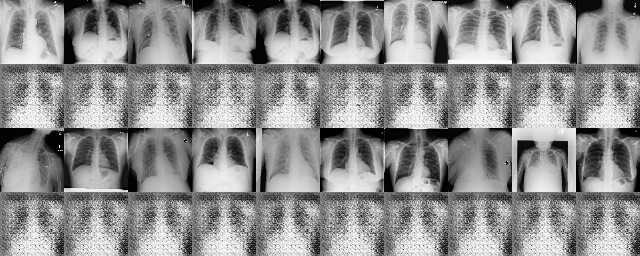

/content/gan_project/utils.py:205: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)


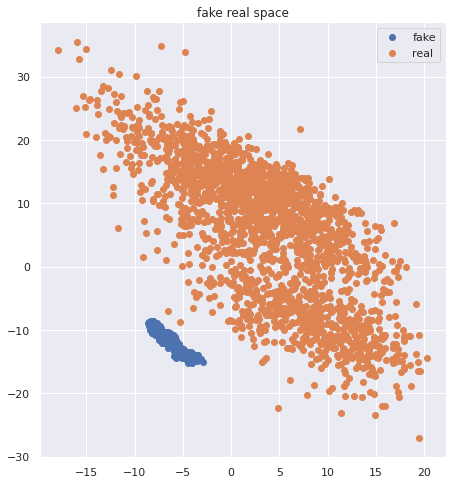

/content/gan_project/utils.py:205: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)


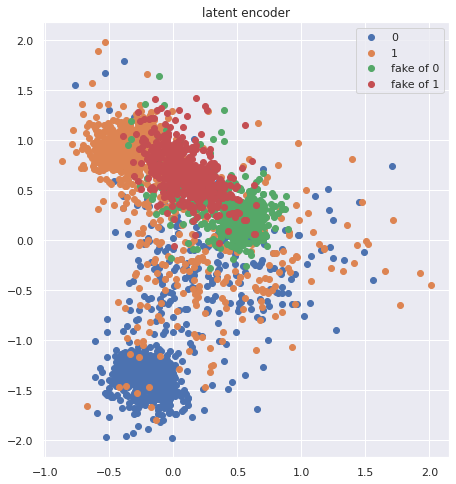

- D_loss 1.2044332067171732, G_adv_loss -0.49199220538139343 G_mse_loss 0.040381330996751785 - 0:01:24.460211
GAN train epoch: 2/400000


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


- D_loss 1.497471777598063, G_adv_loss -1.2096459865570068 G_mse_loss 0.03389429673552513 - 0:00:41.280679
GAN train epoch: 3/400000
- D_loss 1.5618549823760985, G_adv_loss -1.4716928005218506 G_mse_loss 0.023985017091035843 - 0:00:41.177144
GAN train epoch: 4/400000
- D_loss 1.5090559403101602, G_adv_loss -1.3726050853729248 G_mse_loss 0.040419355034828186 - 0:00:41.016422
GAN train epoch: 5/400000
- D_loss 1.4526106754938761, G_adv_loss -1.3216947317123413 G_mse_loss 0.032439474016427994 - 0:00:41.006695
GAN train epoch: 6/400000
- D_loss 1.4180968443552653, G_adv_loss -1.3920767307281494 G_mse_loss 0.04521370306611061 - 0:00:40.882658
GAN train epoch: 7/400000
- D_loss 1.3583046356836954, G_adv_loss -1.3758260011672974 G_mse_loss 0.03227834030985832 - 0:00:41.845048
GAN train epoch: 8/400000
- D_loss 1.3449947436650593, G_adv_loss -1.3487597703933716 G_mse_loss 0.0341002494096756 - 0:00:41.943272
GAN train epoch: 9/400000
- D_loss 1.3109348217646282, G_adv_loss -1.1981055736541748 G

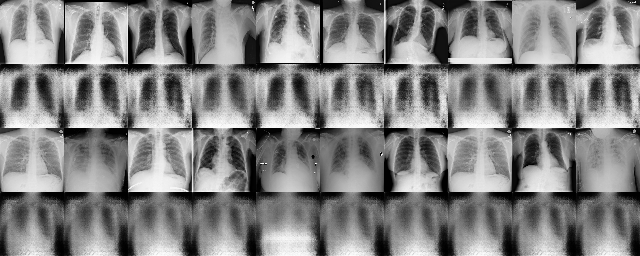

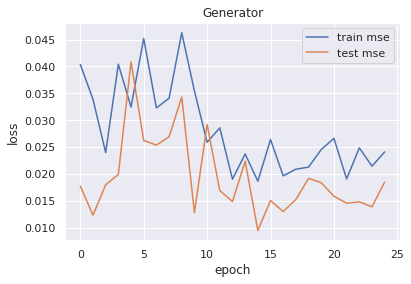

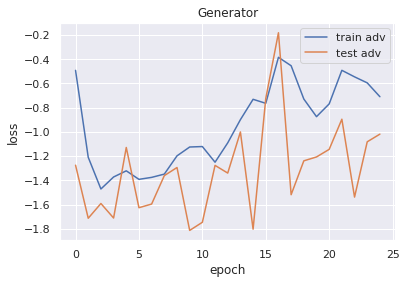

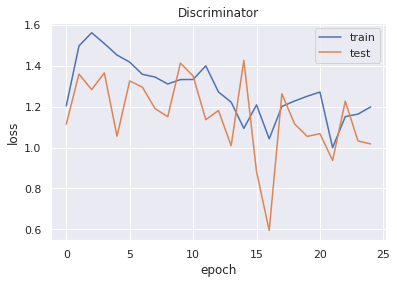

/content/gan_project/utils.py:205: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)


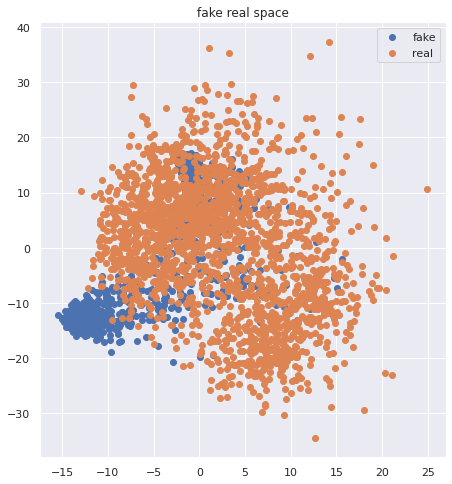

/content/gan_project/utils.py:205: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)


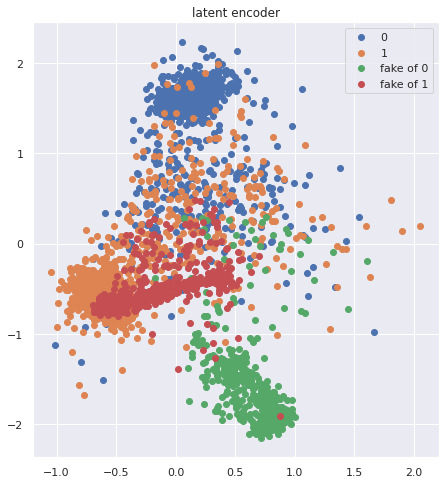

- D_loss 1.2479424397150676, G_adv_loss -0.8569619655609131 G_mse_loss 0.0197580736130476 - 0:00:56.856463
GAN train epoch: 27/400000


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


- D_loss 1.1557884454727172, G_adv_loss -0.8247454762458801 G_mse_loss 0.02686111070215702 - 0:00:40.513050
GAN train epoch: 28/400000
- D_loss 1.2080904642740886, G_adv_loss -0.8040181398391724 G_mse_loss 0.024465182796120644 - 0:00:40.092068
GAN train epoch: 29/400000
- D_loss 1.2431606769561767, G_adv_loss -0.9093053340911865 G_mse_loss 0.02229410782456398 - 0:00:40.070687
GAN train epoch: 30/400000
- D_loss 1.2015539566675821, G_adv_loss -0.9050318598747253 G_mse_loss 0.03221399337053299 - 0:00:40.208485
GAN train epoch: 31/400000
- D_loss 1.162621545791626, G_adv_loss -0.9540956020355225 G_mse_loss 0.020248835906386375 - 0:00:39.627856
GAN train epoch: 32/400000
- D_loss 1.2335292975107828, G_adv_loss -0.9639219641685486 G_mse_loss 0.018839331343770027 - 0:00:39.757318
GAN train epoch: 33/400000
- D_loss 1.2324257612228393, G_adv_loss -1.0072803497314453 G_mse_loss 0.018786907196044922 - 0:00:39.635408
GAN train epoch: 34/400000
- D_loss 1.1528181314468384, G_adv_loss -0.884622335

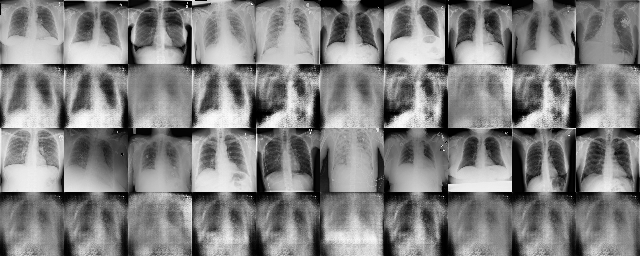

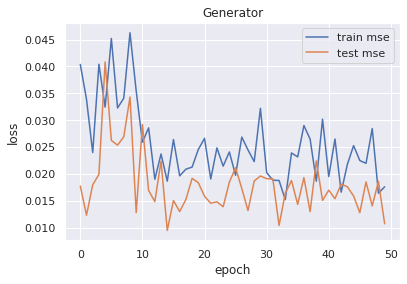

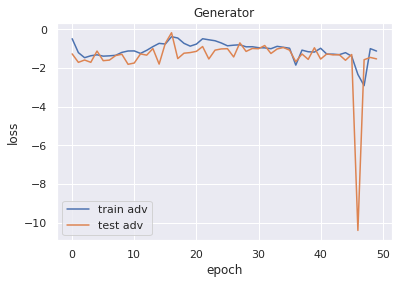

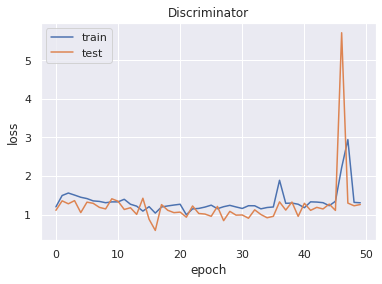

/content/gan_project/utils.py:205: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)


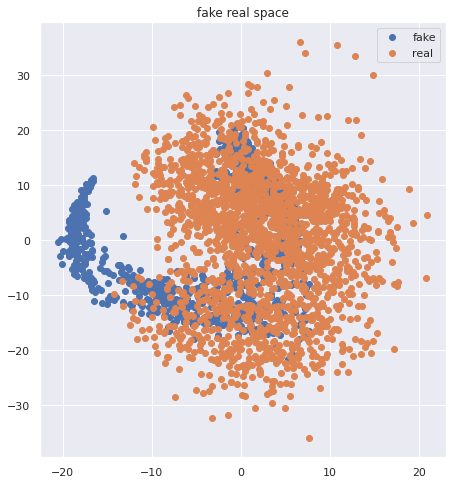

/content/gan_project/utils.py:205: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)


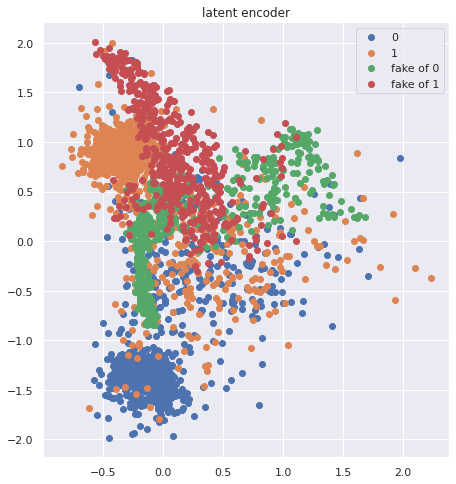

- D_loss 1.3332393407821654, G_adv_loss -1.2292414903640747 G_mse_loss 0.02094058319926262 - 0:00:55.895250
GAN train epoch: 52/400000


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


- D_loss 1.3375265836715697, G_adv_loss -1.2811698913574219 G_mse_loss 0.01850363425910473 - 0:00:39.326225
GAN train epoch: 53/400000
- D_loss 1.2857557694117228, G_adv_loss -1.2224066257476807 G_mse_loss 0.02090703509747982 - 0:00:39.642389
GAN train epoch: 54/400000
- D_loss 1.471471079190572, G_adv_loss -1.5463042259216309 G_mse_loss 0.015292208641767502 - 0:00:38.938606
GAN train epoch: 55/400000
- D_loss 1.3318300167719523, G_adv_loss -1.2844079732894897 G_mse_loss 0.02999795600771904 - 0:00:39.231941
GAN train epoch: 56/400000
- D_loss 1.3037657658259074, G_adv_loss -1.3176251649856567 G_mse_loss 0.012369551695883274 - 0:00:38.746765
GAN train epoch: 57/400000
- D_loss 1.3427000761032104, G_adv_loss -1.2984600067138672 G_mse_loss 0.01570744439959526 - 0:00:39.033570
GAN train epoch: 58/400000
- D_loss 1.4984169642130534, G_adv_loss -1.661697506904602 G_mse_loss 0.0211616400629282 - 0:00:38.757664
GAN train epoch: 59/400000
- D_loss 2.1080014228820803, G_adv_loss -2.3493814468383

In [ ]:
gan_epochs  = 400000
# Discriminator learning rate
adam_lr = 0.0004
# Generator learning rate
g_lr = 0.0001
batch_size = 128
# dataset_name should be "flowers", "chest", "multi_chest"
# "chest" is binary classification, "multi_chest" using chest-xray14 dataset
dataset_name = 'multi_chest'
latent_size = 128
# Use resnet architecture for Generator
resnet = True
# Use self-attention mechanism
attention = False
np.random.seed(0)
# Image resoulution
rst = 64
# Number of images used to generate feature for Generator should be 2 - 5
k_shot = 2

# normal: sampling from normal distribution
# code: sampling from latent code distribution (computed by classifier)
sampling = 'code'

"""
batch: batch norm
in: instance norm
fn: feature norm
D-fn: use feature norm for Discriminator
"""
norm = 'fn-in-bn'
# Adversarial loss type
loss_type = 'hinge'

is_prune = False

# prune = [700] * 11 if is_prune else None
prune = [0,2500] if is_prune else None

res_dir = BASE_DIR + '/result/model_v2_{}'.format(rst)
create_dir_if_any(res_dir)

bg_train_full = BatchGen(BatchGen.TRAIN, batch_size, dataset_name, rst,prune_classes=prune)
bg_test = BatchGen(BatchGen.TEST, batch_size, dataset_name, rst)

channels = bg_train_full.dataset_x[0].shape[-1]

print("input data loaded...")

shape = bg_train_full.dataset_x[0].shape

print('img shape', shape)
classes = bg_train_full.get_label_table()
# Initialize statistics information
gan_train_losses = defaultdict(list)
gan_test_losses = defaultdict(list)

img_samples = defaultdict(list)

# For all possible minority classes.
target_classes = np.array(range(len(classes)))


print('Class counters: ', bg_train_full.per_class_count)

# Train GAN to balance the data
gan = Bagan(
    target_classes, loss_type,
    adam_lr=adam_lr, latent_size=latent_size,res_dir=res_dir,image_shape=shape,
    g_lr = g_lr,
    norm = norm,
    resnet=resnet,
    dataset=dataset_name,
    attention=attention,
    k_shot=k_shot,
    sampling=sampling,
)
print(gan.combined.metrics_names)
print(gan.discriminator_fake.metrics_names)

# plot_model(gan.generator, to_file=BASE_DIR + '/gen.png')
# gan.init_gan()
gan.train(bg_train_full, bg_test, epochs=gan_epochs)

In [10]:
import seaborn as sns
sns.set(color_codes=True)
for i in range(gan.nclasses):
    print("Distribution class ", i)
    # x = np.random.multivariate_normal(gan.means[i], gan.covariances[i])
    # sns.distplot(x)


Distribution class  0
Distribution class  1
Distribution class  2
Distribution class  3


False

Test classifier model


In [ ]:
def l2_dist(x, y):
    return np.mean(np.square(x - y))
def cosine_sim(a, b):
    return -np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

def pred(sp1, sp2, x, opt='l2'):
    metric = l2_dist if opt == 'l2' else cosine_sim
    dis_1 = metric(x, sp1)
    dis_2 = metric(x, sp2)
    # if opt == 'l2':
        # print('Dis_2, Dis_1', dis_2 ,dis_1)
    if dis_1 < dis_2:
        return 0
    return 1

test_size = 1000
test_data = True
bg = bg_test if test_data else bg_train_full
sp_1 = bg.get_samples_for_class(2, 1) # class normal 
sp_2 = bg.get_samples_for_class(3, 1) # pneumonia
query_1 = bg.get_samples_for_class(2, test_size)
query_2 = bg.get_samples_for_class(3, test_size)

# query_1 = gan.generator.predict([query_1, gan.generate_latent(query_1)])
# query_2 = gan.generator.predict([query_2, gan.generate_latent(query_2)])

s_embedding_1 = gan.latent_encoder.predict(triple_channels(sp_1))
s_embedding_2 = gan.latent_encoder.predict(triple_channels(sp_2))

q_embedding_1 = gan.latent_encoder.predict(triple_channels(query_1))
q_embedding_2 = gan.latent_encoder.predict(triple_channels(query_2))

# labels = [0] * len(q_embedding_1) + [1] * len(q_embedding_2)
acc_count = 0
acc_count_2 = 0
for e in q_embedding_1:
    if pred(s_embedding_1[0], s_embedding_2[0], e) == 0:
        acc_count += 1
    if pred(s_embedding_1[0], s_embedding_2[0], e, 'cs') == 0:
        acc_count_2 += 1

for e in q_embedding_2:
    if pred(s_embedding_1[0], s_embedding_2[0], e) == 1:
        acc_count += 1
    if pred(s_embedding_1[0], s_embedding_2[0], e, 'cs') == 1:
        acc_count_2 += 1

actual_size = len(query_1) + len(query_2)
print('L2 Accuracy: ', acc_count / actual_size, '{}/{}'.format(acc_count, actual_size))
print('Cosine Accuracy: ', acc_count_2 / actual_size, '{}/{}'.format(acc_count_2, actual_size))
plot_data_space(np.concatenate([sp_1, sp_2, query_1, query_2]),
          np.array(['nor'] + ['pneu'] + ['fake_nor']*len(query_1) + ['fake_pneu']*len(query_2)),
          gan.latent_encoder,'a')

In [ ]:
self = gan
bg = bg_train_full
size=500

x, y = bg.dataset_x, bg.dataset_y
real = bg.ramdom_kshot_images(self.k_shot,
                            np.full(size, 0))
fakes = self.generator.predict([real,
                                self.generate_latent(range(size))])
fake_labels = [np.full((size,), 'fake of 0')]

for classid in range(1, min(self.nclasses, 5)):
    real = bg.ramdom_kshot_images(self.k_shot,
                            np.full(size, classid))
    fake = self.generator.predict([real, self.generate_latent(range(size))])
    fakes = np.concatenate([fakes, fake])
    fake_labels.append(np.full((size,), 'fake of {}'.format(classid)))

# latent_encoder
    imgs = np.concatenate([x, fakes])
    labels = np.concatenate([
        np.full((x.shape[0],), 'real'),
        np.full((fakes.shape[0],), 'fake'),
    ])

utils.plot_data_space(imgs, labels, self.features_from_d_model, 'fake real space')

# labels = np.concatenate([y, np.concatenate(fake_labels)])
# utils.plot_data_space(imgs, labels, self.latent_encoder, 'latent encoder')

In [ ]:
epoch = 300
print('Save weights at epochs : ', epoch)
generator_fname = "{}/bck_generator.h5".format(gan.res_dir)
discriminator_fname = "{}/bck_discriminator.h5".format(gan.res_dir)

gan.generator.save(generator_fname)
gan.discriminator.save(discriminator_fname)

Plot data

In [ ]:
bg = bg_train_full
x, y = bg.dataset_x, bg.dataset_y

test_size = 500

class_1 = bg.ramdom_kshot_images(k_shot, np.full(test_size, 0))
class_2 = bg.ramdom_kshot_images(k_shot, np.full(test_size, 1))

fake_1 = gan.generator.predict([class_1,
                                gan.generate_latent(range(test_size))])

fake_2 = gan.generator.predict([class_2,
                                gan.generate_latent(range(test_size))])

x = np.concatenate([x, fake_1, fake_2])
y = np.concatenate([y, np.full((test_size,), 'Pneu'),  np.full((test_size,), 'Normal')])
# utils.plot_data_space(x, y, gan.features_from_d_model, 'latent encoder')
# utils.plot_data_space(x, y, gan.latent_encoder, 'latent encoder')

print(np.mean(np.abs(gan.latent_codes(class_2) - gan.latent_codes(class_1))))

show_samples(class_1[:,0,][:10])
show_samples(fake_1[:10])
show_samples(class_2[:,0,][:10])
show_samples(fake_2[:10])

Test generated image

In [ ]:

# bg = bg_test
bg = bg_train_full
idx = np.random.randint(0, 200) 
ss = np.random.randint(0, 200)
x = bg.dataset_x[idx]
rst = x.shape[1]
x = np.expand_dims(x, axis = 0)
channels= 1
if 1 == 1:
    y = bg.dataset_x[ss].reshape(1,rst,rst,channels)
else:
    y = bg.dataset_x[ss:ss + 10]

label_x, label_y = bg.dataset_y[idx], bg.dataset_y[ss]
label_x_r = 1 if label_x == 0 else 0
label_y_r = 1 if label_y == 0 else 0
latent = gan.generate_latent(range(10))
latent = np.random.uniform(0.3, 1, 10*128).reshape(10,128)

size = 0
latent = np.concatenate([
    np.full((1, size), 0),
    np.full((1, 128 - size), 1)
], axis = -1)


gen = gan.generator.predict([x, np.random.normal(0, 1, 128).reshape(1,128)])
attr_img = x
for i in range(9):
    temp = bg.get_samples_for_class(label_x_r, 1)
    img2 = gan.generator.predict([temp, latent])
    gen = np.concatenate([gen, img2])
    attr_img = np.concatenate([attr_img, temp])

gen2 = gan.generator.predict([y, np.random.normal(0, 1, 128).reshape(1,128)])
attr_img2 = y
for i in range(9):
    temp = bg.get_samples_for_class(label_y_r, 1)
    img2 = gan.generator.predict([temp, latent])
    gen2 = np.concatenate([gen2, img2])
    attr_img2 = np.concatenate([attr_img2, temp])



def percep(x):
    return gan.perceptual_model.predict(
        triple_channels(x)
    )


# pred1 = np.argmax(gan.discriminator.predict(x))
# pred2 = np.argmax(gan.discriminator.predict(y))
# pred3 = np.argmax(gan.discriminator.predict(gen[2:3]))
# pred4 = np.argmax(gan.discriminator.predict(gen2[2:3]))
print('label_x, label_y: ', label_x, label_y)
# print('x, y, x2y, y2x: ' ,pred1,pred2,pred3,pred4)



show_samples(x)
show_samples(y)
show_samples(attr_img)
show_samples(gen)
show_samples(attr_img2)
show_samples(gen2)

def dis(x,y):
    x = np.expand_dims(x, axis=0)
    y = np.expand_dims(y, axis=0)
    f1=gan.latent_encoder.predict(x)
    f2=gan.latent_encoder.predict(y)
    return np.mean(np.square(f1 -f2))


print('fake dis: ')
print(dis(gen[0], gen[1]))
print(dis(gen[0], gen2[2]))
print('real dis: ')
print(dis(attr_img[0], attr_img[1]))
print(dis(attr_img[0], attr_img2[2]))

Save generative image

In [ ]:
bg = bg_test
size = 20
x = bg.get_samples_for_class(0, size)
y = bg.get_samples_for_class(1, size)
images = x[0:1]
labels  = []
latent = np.random.normal(0, 1, 128).reshape(1, 128)

print('generate image for class 1: x -> y')
## generate image for class 1: x -> y
for i in range(size):
    for j in range(size):
        new_img = gan.generator.predict([x[i:i+1], y[j:j+1], latent])
        images = np.concatenate([images, new_img])
        labels.append(1)

## generate image for class 0: y -> x
print('generate image for class 0: y -> x')
for i in range(size):
    for j in range(size):
        new_img = gan.generator.predict([y[i:i+1], x[j:j+1], latent])
        images = np.concatenate([images, new_img])
        labels.append(0)

res = (images * 127.5 + 127.5, np.array(labels))
pickle_save(res, '/content/drive/My Drive/bagan/dataset/gen/imgs_train_64.pkl')